In [108]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import os
import PIL
from PIL import ImageDraw
from PIL import ImageFont
plt.style.use('ggplot')


# Evaluation of Object Detection Model

After training the object detection model, we use it to make predictions on the test samples. The predictions consist of the detected object labels, bounding boxes for each detected object, and confidence scores for each detection.

Evaluation of object detection models is typically done using several metrics:

1. **Precision (P)**: Precision is the ratio of correctly predicted positive observations (true positives) to the total predicted positives. It answers the question "What proportion of positive identifications was actually correct?".

2. **Recall (R)**: Recall (also known as sensitivity) is the ratio of correctly predicted positive observations to all the actual positives. It answers the question "What proportion of actual positives was identified correctly?".

3. **F1-Score**: The F1 Score is the weighted average of Precision and Recall. It tries to find the balance between precision and recall. It is a good measure to use if you have both false positives and false negatives in your test data.

4. **Average Precision (AP)**: Average Precision computes the average value of precision over the range of recall values. The mean Average Precision (mAP) is often used in deep learning-based object detection, and it's the mean of APs for all classes.

5. **Intersection over Union (IoU)**: IoU is the ratio of the area of overlap and the area of union between the predicted and actual bounding boxes. It is often used as a measure of how well the predicted bounding box overlaps with the true box.

For our specific task of chess piece detection, the key points of interest would be:

- **High Precision**: As chess is a game of accurate movements, a higher precision would mean that when our model predicts a chess piece, it is indeed a chess piece most of the time.

- **High Recall**: It is equally important that we are able to detect all the chess pieces present on the board. A higher recall would mean that our model can correctly identify most of the chess pieces on the board.

- **High IoU**: The bounding box predictions should overlap significantly with the ground truth boxes. Hence, a high average IoU would be desirable.
- **High Accuarcy**: The accuarcay in this case refers to the same FEN string as in the generation

In [233]:
classes= {"empty_white":0,
"empty_black":1,
"black_pawn":2,
"black_rook":3,
"black_knight":4,
"black_bishop":5,
"black_queen":6,
"black_king":7,
"white_pawn":8,
"white_rook":9,
"white_knight":10,
"white_bishop":11,
"white_queen":12,
"white_king":13
}

inv_cl = { v:k for k,v in classes.items()}

fen_to_class = {
    'P': 8, 'R': 9, 'N': 10, 'B': 11, 'Q': 12, 'K': 13,
    'p': 2, 'r': 3, 'n': 4, 'b': 5, 'q': 6, 'k': 7,
    '/': '\n','1':1, '1':0 # new line for each rank
}

class_to_fen = { v:k for k,v in fen_to_class.items()}
class_to_fen[1]='1'

In [3]:
predicted_data =np.loadtxt('Predictions/test/labels/-53751548957539434.txt')
ground_truth_data = np.loadtxt('custom_data/labels/test/-53751548957539434.txt')

In [4]:
def calc_tile_assigment(ground_truth_data, predicted_data, k=64):
    """
    This function calculates the assignment of predicted bounding boxes to ground truth bounding boxes based on the minimum sum of Manhattan distances (also known as city block distances). 

    Parameters:
    ground_truth_data (array): An array of ground truth data, where each row corresponds to a bounding box and the columns represent the class label and the coordinates of the bounding box center.
    predicted_data (array): An array of predicted data in the same format as ground_truth_data. The first k rows are used.
    k (int, optional): The number of predictions to consider. Default is 64 menaing the whole board. The predicted data needs to sorted by confidence for this function to mkae senese.

    Returns:
    matches (list): A list of tuples where each tuple contains the ground truth label and the predicted label for a matched pair of bounding boxes.
    unmatched_predictions (list): A list of rows from predicted_data that were not matched to any ground truth bounding box.
    unmatched_ground_truth (list): A list of rows from ground_truth_data that were not matched to any predicted bounding box.
    """
    ground_truth_coordinates = ground_truth_data[:,1:3]
    predicted_coordinates = predicted_data[0:k,1:3]

    distance_matrix = cdist(predicted_coordinates, ground_truth_coordinates, 'cityblock')

    row_indices, col_indices = linear_sum_assignment(distance_matrix)

    matches = []
    for row_idx, col_idx in zip(row_indices, col_indices):
        predicted_label = predicted_data[row_idx,0]
        ground_truth_label = ground_truth_data[col_idx,0]
        matches.append((ground_truth_label, predicted_label))

    unmatched_predictions = [predicted_data[idx,:] for idx in range(len(predicted_coordinates)) if idx not in row_indices]
    unmatched_ground_truth = [ground_truth_data[idx,:] for idx in range(len(ground_truth_coordinates)) if idx not in col_indices]

    return matches, unmatched_predictions, unmatched_ground_truth


def check_matches(list_of_tuples):
    """
    This function checks if all pairs of labels in a list of tuples are equal.

    Parameters:
    list_of_tuples (list): A list of tuples where each tuple contains a pair of labels.

    Returns:
    True if all pairs of labels are equal, False otherwise.
    """
    for tuple_item in list_of_tuples:
        if tuple_item[0] != tuple_item[1]:
            return False
    return True

In [5]:
matches, unm_pred, unm_gt = calc_tile_assigment(ground_truth_data, predicted_data)
check_matches(matches)

True

In [6]:
def compute_iou(box1, box2):
    """
    This function computes the Intersection over Union (IoU) metric between two bounding boxes.

    Parameters:
    box1, box2 (list or array-like): The bounding boxes to compare, each represented as a list or array [x, y, w, h], where:
        - (x, y) are the coordinates of the top left corner of the bounding box
        - w and h are the width and height of the bounding box

    Returns:
    iou (float): The Intersection over Union value for the two bounding boxes, which ranges from 0 (no overlap) to 1 (perfect overlap).

    Notes:
    Intersection over Union is a measure of the overlap between two bounding boxes. It's often used in object detection to measure how well the predicted bounding boxes match the ground truth boxes.
    """
    x1, y1, w1, h1 = box1[0],box1[1],box1[2],box1[3]
    x2, y2, w2, h2 = box2[0],box2[1],box2[2],box2[3]

    # Calculate the (x, y) coordinates of the intersection rectangle
    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1+w1, x2+w2)
    yB = min(y1+h1, y2+h2)

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both the prediction and ground-truth rectangles
    box1Area = w1 * h1
    box2Area = w2 * h2

    # Compute the intersection over union by taking the intersection area and
    # dividing it by the sum of prediction + ground-truth areas - intersection area
    iou = interArea / float(box1Area + box2Area - interArea)

    # Return the intersection over union value
    return iou

In [7]:
conf_ths=0.7
iou_ths =0.9999
class_matrix = np.zeros((14,3))
conf_matrix = np.zeros((14,14))


def sample_prediction (sample_data, ground_truth_data, iou_ths, conf_ths, class_matrix, confusion_matrix):
    """
    This function processes a single sample of predicted data against the ground truth data. It computes the Intersection over Union (IoU) for predicted and ground truth bounding boxes, and updates the confusion matrix and class matrix based on the match and IoU score. 

    Parameters:
    sample_data (array): An array of predicted data, where each row corresponds to a predicted bounding box and the columns represent the class label, coordinates of the bounding box center, box width, height, and prediction confidence.
    ground_truth_data (array): An array of ground truth data in the same format as sample_data (excluding the confidence).
    iou_ths (float): The IoU threshold for considering a predicted bounding box as a match.
    conf_ths (float): The confidence threshold for considering a prediction.
    class_matrix (array): A 2D array for storing counts of true positives, false positives, and false negatives for each class.
    confusion_matrix (array): A 2D array for storing counts of each predicted class vs true class.

    Returns:
    class_matrix (array): The updated class matrix.
    confusion_matrix (array): The updated confusion matrix.

    Notes:
    The function computes IoU for each predicted bounding box against all ground truth boxes. If IoU exceeds the threshold, the function checks for class match. Depending on whether the classes match and the confidence exceeds the threshold, the function updates the class and confusion matrices accordingly. If no ground truth box matches a prediction, it's counted as a false positive. Any ground truth boxes not matched by predictions are counted as false negatives.
    """
    gt_ar =  np.full(ground_truth_data.shape[0], False)
    for i in range(sample_data.shape[0]):
        if sample_data[i,-1]> conf_ths:
            pred_class = int(sample_data[i,0])
            possible_samples =[]
            for j in range(ground_truth_data.shape[0]):
                iou = compute_iou(ground_truth_data[j,1:5],sample_data[i,1:5])
                
                if iou > iou_ths:
                    possible_samples.append(ground_truth_data[j,:])
                    gt_ar[j] = True
                    
            if len(possible_samples) > 0:
                for k in range(len(possible_samples)):
                    true_class = int(possible_samples[k][0])
                    confusion_matrix[true_class,pred_class] +=1
                    #TP matching iou and class
                    if true_class == pred_class:
                        class_matrix[true_class,0]+=1
                    # FP matching iou and but not class
                    else:
                        class_matrix[true_class,1]+=1

            else:
                #FP have bounding box but no iou for gt
                class_matrix[pred_class,1]+=1

    #Any gt bounding boxes missing
    if np.any(gt_ar == False):
        for v in range(len(gt_ar)):
            if gt_ar[v] == False:
                #FN missing bounding box in pred
                class_matrix[int(ground_truth_data[v,0]),2]+=1

    return class_matrix, confusion_matrix


sample_prediction(predicted_data,ground_truth_data, iou_ths,conf_ths, class_matrix, conf_matrix)

(array([[0., 2., 2.],
        [0., 3., 3.],
        [0., 4., 4.],
        [0., 4., 4.],
        [0., 4., 4.],
        [0., 2., 2.],
        [0., 5., 5.],
        [0., 4., 4.],
        [0., 9., 9.],
        [0., 3., 3.],
        [0., 7., 7.],
        [0., 6., 6.],
        [0., 6., 6.],
        [0., 5., 5.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [8]:
def calculate_metric_all_samples(path_gt, path_pred, iou_ths, conf_ths):
    """
    This function calculates metrics for all samples given paths to directories with predicted and ground truth data. It initializes class and confusion matrices and updates them for each sample.

    Parameters:
    path_gt (str): Path to the directory containing ground truth .txt files.
    path_pred (str): Path to the directory containing predicted .txt files.
    iou_ths (float): The IoU threshold for considering a predicted bounding box as a match.
    conf_ths (float): The confidence threshold for considering a prediction.

    Returns:
    class_matrix (array): A 2D array for storing counts of true positives, false positives, and false negatives for each class across all samples.
    conf_matrix (array): A 2D array for storing counts of each predicted class vs true class across all samples.

    Notes:
    The function loops over all .txt files in the predicted data directory, loads the predicted data and corresponding ground truth data, and processes each sample using the sample_prediction function. The class and confusion matrices are updated for each sample and returned at the end.
    """
    class_matrix = np.zeros((14,3))
    conf_matrix = np.zeros((14,14))

    for filename in os.listdir(path_pred):
        if filename.endswith('.txt'):
            
            predicted_data =np.loadtxt(path_pred+filename)
            ground_truth_data = np.loadtxt(path_gt+filename)

            class_matrix, conf_matrix = sample_prediction(predicted_data,ground_truth_data, iou_ths,conf_ths, class_matrix, conf_matrix)


    return class_matrix, conf_matrix
    

In [9]:
class_matrix, conf_matrix = calculate_metric_all_samples(path_gt = 'custom_data/labels/test/', path_pred='Predictions/test/labels/', iou_ths=0, conf_ths=0)

In [10]:
def calc_overall_tile_assignment(path_gt, path_pred):
    """
    This function calculates the overall tile assignment for all samples, given paths to directories with predicted and ground truth data. It keeps track of instances of incorrect classification for further inspection.

    Parameters:
    path_gt (str): Path to the directory containing ground truth .txt files.
    path_pred (str): Path to the directory containing predicted .txt files.

    Returns:
    wrong_classification (list): A list of dictionaries, each containing the filename, ground truth data and predicted data for instances where the predicted tile assignment does not match the ground truth.

    Notes:
    The function loops over all .txt files in the predicted data directory, loads the predicted data and corresponding ground truth data, and calculates tile assignments using the calc_tile_assigment function. It checks if the tile assignments match the ground truth using the check_matches function. If they do not match, it adds the filename, ground truth data and predicted data to the wrong_classification list. The function prints the percentage of correctly classified samples and returns the wrong_classification list.
    """

    wrong_classification =[]
    ov_c=0
    cor_c=0
    for filename in os.listdir(path_pred):
        if filename.endswith('.txt'):
            ov_c +=1
            predicted_data =np.loadtxt(path_pred+filename)
            ground_truth_data = np.loadtxt(path_gt+filename)


            matches, unm_pred, unm_gt = calc_tile_assigment(ground_truth_data, predicted_data)
            if not check_matches(matches):
                wrong_classification.append({'file':filename, 'gt':ground_truth_data, 'p':predicted_data })
            else:
                cor_c +=1
    
    print('Correct Classified: %.2f Per.'%(float(cor_c)/float(ov_c)*100))

    return(wrong_classification)



In [11]:
w_cl = calc_overall_tile_assignment(path_gt = 'custom_data/labels/test/', path_pred='Predictions/test/labels/')

Correct Classified: 100.00 Per.


In [12]:
def confidence_distribution(path_pred, k=None):
    """
    This function calculates the distribution of confidence scores for all classes across all samples in the predicted data.

    Parameters:
    path_pred (str): Path to the directory containing predicted .txt files.
    k (int, optional): The number of predicted bounding boxes to consider. If None (default), considers all bounding boxes.

    Returns:
    confidence_dict (dict): A dictionary where keys are class IDs and values are lists of confidence scores for that class across all samples.

    Notes:
    The function initializes an empty dictionary with keys for each class. It then loops over all .txt files in the predicted data directory and loads the predicted data. For each predicted bounding box up to k (or all bounding boxes if k is None), it appends the confidence score to the appropriate list in the dictionary.
    """

    confidence_dict ={}
    for i in range(len(classes.keys())):
        confidence_dict[i] = []
    for filename in os.listdir(path_pred):
        if filename.endswith('.txt'):
            predicted_data =np.loadtxt(path_pred+filename)

            # if k == None:
            #     k = predicted_data.shape[0]

            if predicted_data.ndim == 1:
                predicted_data = predicted_data[np.newaxis, :]
            # Use min to ensure k does not exceed the number of rows
            k = min(k if k else predicted_data.shape[0], predicted_data.shape[0])
            
            for j in range(k):
                confidence_dict[int(predicted_data[j,0])].append( predicted_data[j,-1])

    
    return confidence_dict

In [61]:
conf_dict = confidence_distribution('Predictions/test/labels/', k=64)

In [74]:
def plot_confidence_violinplot(data_dict):
    labels = list(classes.keys())
    confidence_values = list(data_dict.values())

    plt.violinplot(confidence_values, showmedians=True)
    plt.xlabel('Class Label')
    plt.ylabel('Confidence Level')
    plt.title('Confidence Distribution')

    plt.xticks(np.arange(1, len(labels) + 1), labels, rotation=90)

    plt.show()

In [75]:
def plot_confidence_boxplot(data_dict):
    labels = list(classes.keys())
    confidence_values = list(data_dict.values())

    plt.boxplot(confidence_values, labels=labels)
    plt.xlabel('Class Label')
    plt.ylabel('Confidence Level')
    plt.title('Confidence Distribution')

    plt.xticks(rotation=90)

    plt.show()

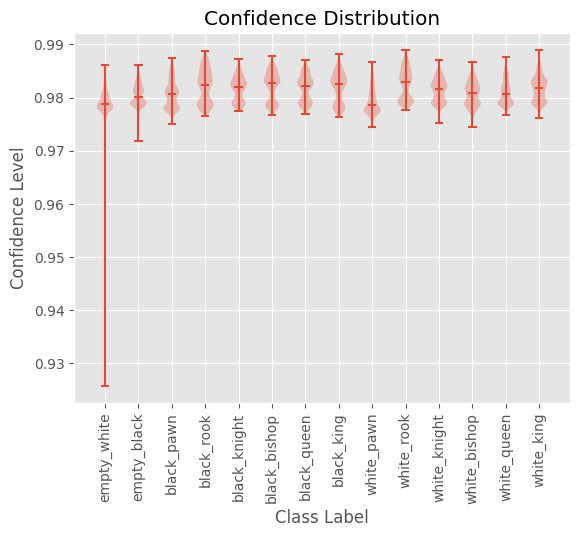

In [76]:
plot_confidence_violinplot(conf_dict)

In [16]:
def plot_all_confidence_boxplot(data_dict):
    labels = ['All Classes'] + list(classes.keys())
    confidence_values = list(data_dict.values())
    all_confidence_values = [[val for sublist in confidence_values for val in sublist]]

    confidence_values = all_confidence_values + confidence_values

    positions = np.array(range(0, len(labels)))-0.5
    #xticks_positions = positions[:-1] + [positions[-1] - 1.]

    # return confidence_values

    plt.boxplot(confidence_values, positions =range(15) , labels=labels)
    plt.xlabel('Class Label')
    plt.ylabel('Confidence Level')
    plt.title('Confidence Distribution')

    plt.xticks(positions,rotation=45)  # Rotate x-labels by 45 degrees

    plt.show()

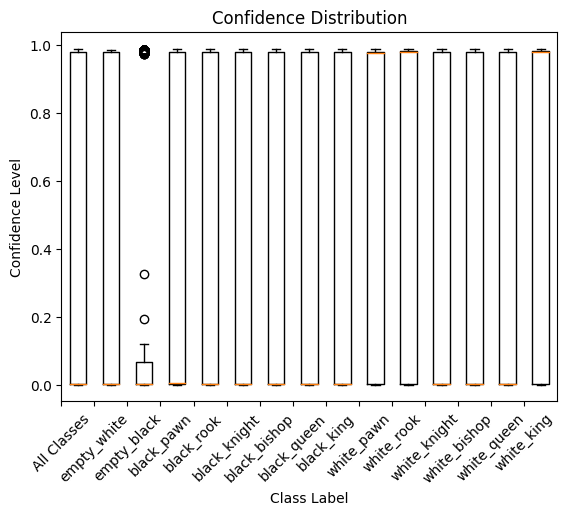

In [17]:
plot_all_confidence_boxplot(conf_dict)

In [18]:
def plot_conf_matrix(conf_mat):
    """
    This function plots a confusion matrix from the given confusion matrix data, where the matrix is normalized by row (i.e., by the true classes) to represent percentages. 

    Parameters:
    conf_mat (numpy.array): The confusion matrix to be plotted. The element at the i-th row and j-th column of this matrix represents the number of samples of class i that were classified as class j.

    Returns:
    None. However, a plot of the confusion matrix will be displayed.

    Notes:
    The confusion matrix is first converted into a percentage format by dividing each row by its sum. The resulting matrix is then plotted as an image, with color intensity reflecting the percentage value. The plot includes a colorbar for reference, and labels for each class along the x and y axes. Furthermore, each cell in the matrix is annotated with the corresponding percentage value.
    """

    row_sums = conf_mat.sum(axis=1, keepdims=True)
    percent_matrix = conf_mat / row_sums * 100

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.imshow(percent_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix (%)")
    plt.colorbar(format='%1.0f%%')

    plt.xticks(np.arange(len(classes.keys())), classes.keys(), rotation =90)
    plt.yticks(np.arange(len(classes.keys())), classes.keys())

    plt.gca().set_xticks(np.arange(-0.5, len(classes.keys()), 1), minor=True)
    plt.gca().set_yticks(np.arange(-0.5, len(classes.keys()), 1), minor=True)

    plt.grid(False)
    plt.grid(color='gray', linestyle='--', linewidth=0.5, which='minor')


    # Add text annotation for each cell
    for i in range(percent_matrix.shape[0]):
        for j in range(percent_matrix.shape[1]):
            if percent_matrix[i, j] > 0:
                plt.text(j, i, format(percent_matrix[i, j], '.1f'),
                        fontsize=9,
                        horizontalalignment="center",
                        verticalalignment="center",
                        color="white" if percent_matrix[i, j] > 50 else "black")

    # Add labels
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.tight_layout()
    plt.show()

In [83]:
class_matrix, conf_matrix = calculate_metric_all_samples(path_gt = 'custom_data/labels/test/', path_pred='Predictions/test/labels/', iou_ths=0.5, conf_ths=0.75)

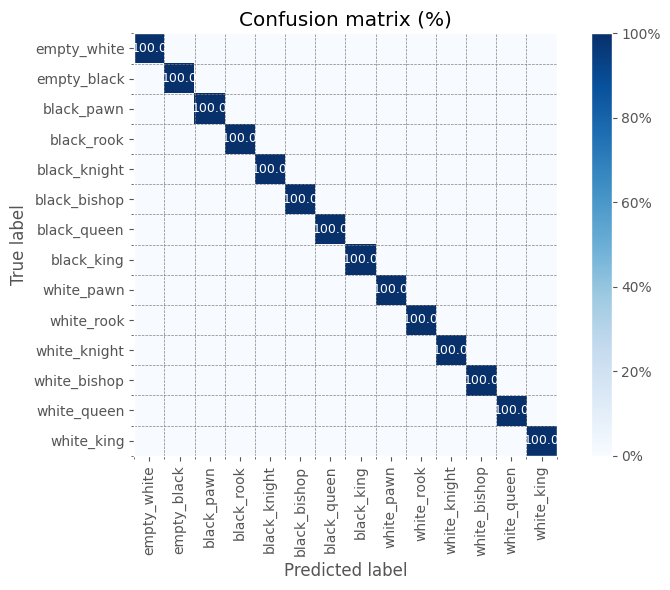

In [84]:
plot_conf_matrix(conf_matrix)

In [20]:
def get_metrics(class_matrix):
    """
    This function calculates the precision, recall, and F1 score for each class and overall based on the input class matrix. It also prints these metrics in a formatted string.

    Parameters:
    class_matrix (numpy.array): A Nx3 matrix, where N is the number of classes. Each row corresponds to a class, the first column represents true positives (TP), the second column false positives (FP), and the third column false negatives (FN) for that class.

    Returns:
    precision (numpy.array): An array of the precision values for each class.
    recall (numpy.array): An array of the recall values for each class.
    f1 (numpy.array): An array of the F1 scores for each class.
    overall_precision (float): The overall precision, calculated across all classes.
    overall_recall (float): The overall recall, calculated across all classes.
    overall_f1 (float): The overall F1 score, calculated across all classes.

    Notes:
    Precision is calculated as TP/(TP+FP), recall is calculated as TP/(TP+FN), and F1 score is calculated as 2 * (precision * recall) / (precision + recall). The 'overall' metrics are calculated by summing the TP, FP, and FN across all classes and then calculating precision, recall, and F1 score.
    """

    output_str = 'class: %s, P: %.3f, R: %.3f, F1: %.3f'

    TP = class_matrix[:, 0]
    FP = class_matrix[:, 1]
    FN = class_matrix[:, 2]

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    final_out = ''
    for i in range(class_matrix.shape[0]):
        final_out = final_out +output_str%(inv_cl[i], precision[i], recall[i], f1[i])+"\n"

    overall_TP = np.sum(TP)
    overall_FP = np.sum(FP)
    overall_FN = np.sum(FN)

    overall_precision = overall_TP / (overall_TP + overall_FP)
    overall_recall = overall_TP / (overall_TP + overall_FN)
    overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall)

    final_out +=output_str%('All', overall_precision, overall_recall, overall_f1)

    #print(final_out)
    return precision, recall, f1, overall_precision, overall_recall, overall_f1

    

In [48]:
conf_thresholds = np.arange(0,1.001,0.001)
iou_thresholds = np.linspace(0.05, 0.05, 1, endpoint=True)

for iou_ths in iou_thresholds:

    precision_all_classes = []
    recall_all_classes = []
    f1_all_classes = []
    precision_overall = []
    recall_overall = []
    f1_overall = []

    for conf_ths in conf_thresholds:
        class_matrix, conf_matrix = calculate_metric_all_samples(path_gt='custom_data/labels/test/', path_pred='Predictions/test/labels/', iou_ths=iou_ths, conf_ths=conf_ths)
        precision, recall, f1, overall_precision, overall_recall, overall_f1 = get_metrics(class_matrix)

        precision_all_classes.append(precision)
        precision_overall.append(overall_precision)

        recall_all_classes.append(recall)
        recall_overall.append(overall_recall)

        f1_all_classes.append(f1)
        f1_overall.append(overall_f1)
    
    stacked_overall_precision = np.vstack(precision_overall)
    stacked_precision = np.vstack(precision_all_classes)

    stacked_overall_recall = np.vstack(recall_overall)
    stacked_recall = np.vstack(recall_all_classes)

    stacked_overall_f1 = np.vstack(f1_overall)
    stacked_f1 = np.vstack(f1_all_classes)

    num_arrays, num_indices = stacked_precision.shape

/var/folders/vf/3c15r53d41b33yfdfy7mjv600000gn/T/ipykernel_46004/2698470604.py:26: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)
/var/folders/vf/3c15r53d41b33yfdfy7mjv600000gn/T/ipykernel_46004/2698470604.py:37: RuntimeWarning: invalid value encountered in double_scalars
  overall_precision = overall_TP / (overall_TP + overall_FP)


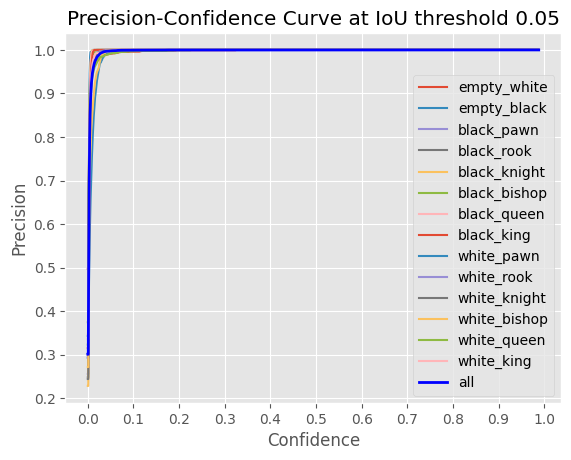

In [49]:
for i in range(num_indices):
        precision_values = stacked_precision[:, i]
        plt.plot(conf_thresholds, precision_values, label=inv_cl[i])

overall_precision_values = stacked_overall_precision[:, 0]
plt.plot(conf_thresholds, overall_precision_values, label='all', linewidth=2, color="blue")

# Set the plot title and labels
plt.title("Precision-Confidence Curve at IoU threshold " + str(iou_ths))
plt.xlabel("Confidence")
plt.ylabel("Precision")

# Set ticks on the x-axis
plt.xticks(np.arange(min(conf_thresholds), max(conf_thresholds)+0.1, 0.1))

# Add a legend
plt.legend()
output_filename = "precision_confidence_curve_iou_" + str(iou_ths) + ".png"
plt.savefig(output_filename)


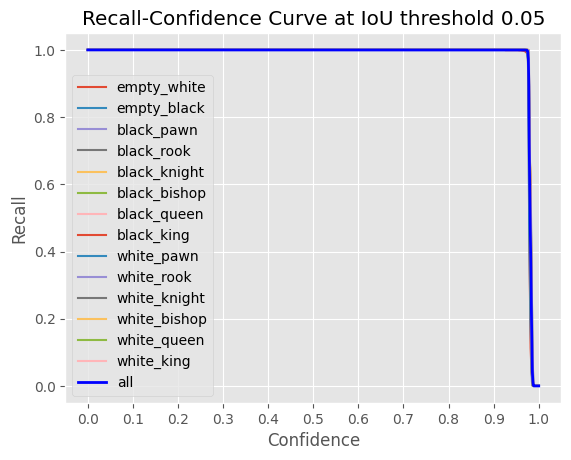

In [50]:
for i in range(num_indices):
        recall_values = stacked_recall[:, i]
        plt.plot(conf_thresholds, recall_values, label=inv_cl[i])

overall_recall_values = stacked_overall_recall[:, 0]
plt.plot(conf_thresholds, overall_recall_values, label='all', linewidth=2, color="blue")

# Set the plot title and labels
plt.title("Recall-Confidence Curve at IoU threshold " + str(iou_ths))
plt.xlabel("Confidence")
plt.ylabel("Recall")

# Set ticks on the x-axis
plt.xticks(np.arange(min(conf_thresholds), max(conf_thresholds)+0.1, 0.1))

# Add a legend
plt.legend()
output_filename = "recall_confidence_curve_iou_" + str(iou_ths) + ".png"
plt.savefig(output_filename)

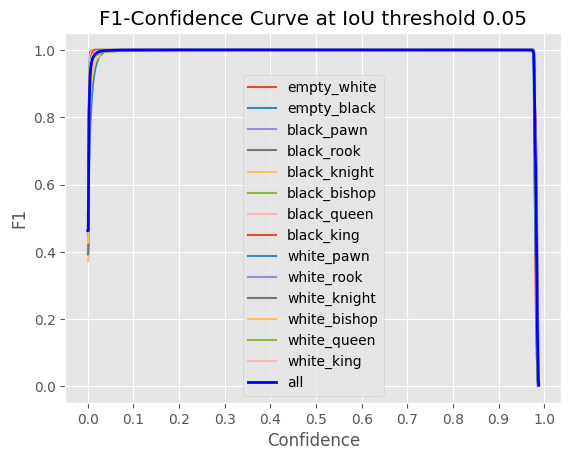

In [51]:
for i in range(num_indices):
        f1_values = stacked_f1[:, i]
        plt.plot(conf_thresholds, f1_values, label=inv_cl[i])

overall_f1_values = stacked_overall_f1[:, 0]
plt.plot(conf_thresholds, overall_f1_values, label='all', linewidth=2, color="blue")

# Set the plot title and labels
plt.title("F1-Confidence Curve at IoU threshold " + str(iou_ths))
plt.xlabel("Confidence")
plt.ylabel("F1")

# Set ticks on the x-axis
plt.xticks(np.arange(min(conf_thresholds), max(conf_thresholds)+0.1, 0.1))

# Add a legend
plt.legend()

output_filename = "f1_confidence_curve_iou_" + str(iou_ths) + ".png"
plt.savefig(output_filename)


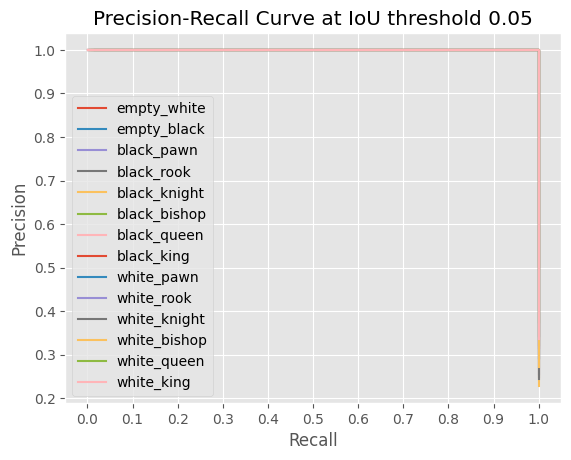

In [52]:
for i in range(num_indices):
        precision_values = stacked_precision[:, i]
        recall_values = stacked_recall[:, i]
        plt.plot(recall_values, precision_values, label=inv_cl[i])

# Set the plot title and labels
plt.title("Precision-Recall Curve at IoU threshold " + str(iou_ths))
plt.xlabel("Recall")
plt.ylabel("Precision")

# Set ticks on the x-axis
plt.xticks(np.arange(min(conf_thresholds), max(conf_thresholds)+0.1, 0.1))

# Add a legend
plt.legend()

output_filename = "precision_recall_curve_iou_" + str(iou_ths) + ".png"
plt.savefig(output_filename)

In [193]:
def draw_labels(img_path, pred_path, k=64):
    """
    Function to draw labels and confidence scores on an image based on predicted bounding box data.

    Args:
        img_path (str): Path to the image file on which labels and scores are to be drawn.
        pred_path (str): Path to the prediction data file. This file should contain rows with class labels,
                         bounding box coordinates, width, height, and confidence scores for each predicted object.
        k (int): Number of top objects to draw on the image, sorted by confidence score in descending order.

    The function opens the image and prediction data files, iterates over the top k objects, and for each object,
    draws the bounding box, label, and confidence score on a transparent overlay. The label and score are positioned 
    such that they are centered in the bounding box. The label is drawn with a smaller font size and the score with 
    a larger font size.

    The label and score each have a semi-transparent rectangle as a background, which improves readability. Finally,
    the function overlays the original image with the overlay and displays the resulting image.
    """
    im = PIL.Image.open(img_path)
    # Convert the image to RGBA if it is not already
    im = im.convert("RGBA")

    # Use an overlay with the same size as the image
    overlay = PIL.Image.new("RGBA", im.size)

    # Use a drawing context on the overlay
    draw = ImageDraw.Draw(overlay)
    
    predicted_data = np.loadtxt(pred_path)
    font_label = ImageFont.truetype(font_path, 11)  # smaller font for label
    font_score = ImageFont.truetype(font_path, 15)  # larger font for confidence score

    for i in range(k):
        row = predicted_data[i:i+1][0]
        cl, xb, yb, widthb, heightb, conf = row[0], row[1], row[2], row[3], row[4], row[5]

        x1, y1 = xb-widthb/2, yb-heightb/2
        x2, y2 = xb+widthb/2, yb+heightb/2

        x1 *= 640
        y1 *= 640
        x2 *= 640
        y2 *= 640

        # Draw the bounding box rectangle on the original image
        ImageDraw.Draw(im).rectangle([x1, y1, x2, y2], outline="red", width=2)

        # Calculate the center coordinates of the bounding box
        x_center = x1 + (x2 - x1) / 2
        y_center = y1 + (y2 - y1) / 2

        # Fetch class label and confidence
        label = inv_cl[int(cl)]
        confidence = conf

        # Create the label string
        label_str = f"{label}"
        confidence_str = f"{confidence:.2f}"

        # Calculate positions for each line
        label_width, label_height = draw.textsize(label_str, font=font_label)
        score_width, score_height = draw.textsize(confidence_str, font=font_score)

        # Calculate positions such that label and score are centered within the bounding box
        label_position = (x_center - label_width / 2, y_center - label_height / 2)
        score_position = (x_center - score_width / 2, y_center + label_height / 2)
        
        # Draw the semi-transparent rectangle on the overlay
        draw.rectangle([label_position[0], label_position[1], label_position[0] + label_width, label_position[1] + label_height], fill=(0, 0, 0, 128))
        draw.rectangle([score_position[0], score_position[1], score_position[0] + score_width, score_position[1] + score_height], fill=(0, 0, 0, 128))

        # Draw the label and confidence at the calculated positions on the overlay
        draw.text(label_position, label_str, fill="white", font=font_label)
        draw.text(score_position, confidence_str, fill="white", font=font_score)

    # Overlay the image and the overlay
    im = PIL.Image.alpha_composite(im, overlay)

    im.show()


In [194]:
draw_labels('custom_data/images/test/3589663954617739376.png', 'Predictions/test/labels/3589663954617739376.txt', 64)

/var/folders/vf/3c15r53d41b33yfdfy7mjv600000gn/T/ipykernel_46004/119844855.py:44: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_width, label_height = draw.textsize(label_str, font=font_label)
/var/folders/vf/3c15r53d41b33yfdfy7mjv600000gn/T/ipykernel_46004/119844855.py:45: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  score_width, score_height = draw.textsize(confidence_str, font=font_score)
/var/folders/vf/3c15r53d41b33yfdfy7mjv600000gn/T/ipykernel_46004/119844855.py:44: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_width, label_height = draw.textsize(label_str, font=font_label)
/var/folders/vf/3c15r53d41b33yfdfy7mjv600000gn/T/ipykernel_46004/119844855.py:45: DeprecationWarning: textsize is deprecated and will be removed in Pillow 

In [265]:
def sort_objects_by_position(objects):
    sorted_objects = sorted(objects, key=lambda obj: (round(obj[2], 1), round(obj[1],1)))
    return sorted_objects


def output_to_fen(prediction_string):
    """
    Generate a FEN string based on object detection predictions.

    Args:
        prediction_string (str): Path to the prediction file or input string.

    Returns:
        str: FEN string representing the positions of detected objects on a chessboard.

    Raises:
        FileNotFoundError: If the specified file path does not exist.
    """
    predicted_data = np.loadtxt(prediction_string)

    # Convert the data to a list
    predicted_data_list = predicted_data.tolist()

    # Sort the data by position
    sorted_data = sort_objects_by_position(predicted_data_list[:64])

    # Extract the first 64 rows and columns 1 and 2
    ordered_data = np.array(sorted_data)[:, 0]

    #return ordered_data

    output_str = ""
    for i in range(64):
        output_str+=class_to_fen[int(ordered_data[i])]
        if (i+1) % 8 == 0 and i+1 != 64:
            output_str+='/'

    return output_str

    

In [266]:
def compare_FEN(predicted_path, ground_truth_path):
    """
    Compare the FEN (Forsyth–Edwards Notation) strings between predicted and ground truth files.

    Args:
        predicted_path (str): Path to the directory containing the predicted FEN files.
        ground_truth_path (str): Path to the directory containing the ground truth FEN files.

    Returns:
        list: List of dictionaries, where each dictionary contains information about incorrectly classified files.
              Each dictionary has the keys 'file' (the filename), 'gt' (the ground truth FEN string), and 'p' (the predicted FEN string).

    """
    
    wrong_classification =[]
    ov_c=0
    cor_c=0
    for filename in os.listdir(predicted_path):
        if filename.endswith('.txt'):
            ov_c +=1
            pred_fen = output_to_fen(predicted_path+filename)
            gt_fen = output_to_fen(ground_truth_path+filename)
            
            if pred_fen != gt_fen:
                wrong_classification.append({'file':filename, 'gt':ground_truth_data, 'p':predicted_data })
            else:
                cor_c +=1
    
    print('Correct Classified: %.2f Per.'%(float(cor_c)/float(ov_c)*100))

    return(wrong_classification)

In [267]:
compare_FEN('Predictions/test/labels/', 'custom_data/labels/test/')

Correct Classified: 100.00 Per.


[]